In [10]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic, linregress
from numba import njit
import h5py as h5

import astropy.units as u

from joblib import Parallel, delayed
from lowda import load_galaxy
import lowda as lwd

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [3]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [4]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [5]:
snapnum = 40
z = meta['redshift'][snapnum]
tuniv = meta['time'][snapnum]

print('snapnum=', snapnum)
print('z=', z)
print('tuniv=', tuniv)

snapnum= 40
z= 1.4955121664955557
tuniv= 4.292907980150009


In [6]:
%%time
sub_fields = ['SubhaloSFRinRad', 'SubhaloMassInRadType', 'SubhaloParent', 
              'SubhaloHalfmassRadType', 'SubhaloPos']
subs = il.groupcat.loadSubhalos(TNGbase, snapnum, fields=sub_fields)

halo_fields = ['GroupFirstSub', 'GroupMassType']
halos = il.groupcat.loadHalos(TNGbase, snapnum, fields=halo_fields)

CPU times: user 2.43 s, sys: 3.49 s, total: 5.92 s
Wall time: 33.3 s


In [7]:
arr = halos['GroupFirstSub']
arr = arr[arr >= 0]
is_central = np.full(len(subs['SubhaloSFRinRad']), False)
is_central[arr] = True

stmass = subs['SubhaloMassInRadType'][:,4]
logstmass = np.log10(1e10*stmass, where=stmass > 0)
in_massband = np.logical_and(10 < logstmass, logstmass < 10.5)

is_central_in_massband = np.logical_and(is_central, in_massband)
subIDs = np.where(is_central_in_massband)[0]

In [42]:
def get_SFH(snapnum, subID, tbins, subs, logFeH0_list, rhalf_fac=2):
    # load snap
    fields = ['Coordinates', 'Masses', 'GFM_StellarFormationTime', 'GFM_Metals']
    snap = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=fields)
    
    # get tform and mass
    tform = get_time(snap['GFM_StellarFormationTime'])
    mass = snap['Masses']
    
    # get stars with rhalf_fac*rhalf of center
    pos = snap['Coordinates'] - subs['SubhaloPos'][subID]
    r = np.linalg.norm(pos, axis=1)
    rhalf = subs['SubhaloHalfmassRadType'][subID,4]
    key = np.logical_and(r < rhalf_fac * rhalf, snap['GFM_StellarFormationTime'] > 0)
    
    # get SFH
    sfh = np.zeros((len(tbins)-1, len(logFeH0_list)+1))
    
    dt = tbins[1] - tbins[0]
    sfh[:,0], edges = np.histogram(tform[key], bins=tbins, weights=10*mass[key]/dt)
    
    tcenter = 0.5 * (edges[1:] + edges[:-1])
    
    # now split by Fe, Mg
    GFM_SOLAR_ABUNDANCE_HYDROGEN  = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON      = 0.0013
    
    FeH = snap['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = snap['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    dlogFeH0 = 0.1
    keys = []
    for i,logFeH0 in enumerate(logFeH0_list):
        in_FeH  = np.logical_and(logFeH > logFeH0 - dlogFeH0/2, logFeH < logFeH0 + dlogFeH0/2)
        in_SN   = np.logical_and(r > rhalf, r < 2*rhalf)
        is_star = snap['GFM_StellarFormationTime'] > 0
        is_star_in_SN = np.logical_and(is_star, in_SN)
        key_    = np.logical_and(np.logical_and(in_FeH, in_SN), is_star)
        
        sfh[:,i+1], edges = np.histogram(tform[key_], bins=tbins, weights=10*mass[key_]/dt/dlogFeH0)
        
        keys.append(key_)
    
    return tcenter, sfh, tform, logFeH, logMgFe, keys, is_star_in_SN


In [51]:
def fit_line(subID, logFeH0_list):
    t_snapnum = meta['time'][snapnum]
    tbins = np.linspace(0, t_snapnum, 100)
    
    tcenter, sfh, tform, logFeH, logMgFe, keys, is_star_in_SN = \
        get_SFH(snapnum, subID, tbins, subs, logFeH0_list)
    
    m = np.zeros(len(keys)+1)
    b = np.zeros(len(keys)+1)
    r = np.zeros(len(keys)+1)
    p = np.zeros(len(keys)+1)
    
    res = linregress(tform[is_star_in_SN], logMgFe[is_star_in_SN])
    m[0] = res.slope
    b[0] = res.intercept
    r[0] = res.rvalue
    p[0] = res.pvalue
    
    for i,key in enumerate(keys):
        res = linregress(tform[key], logMgFe[key])
    
        m[i+1] = res.slope
        b[i+1] = res.intercept
        r[i+1] = res.rvalue
        p[i+1] = res.pvalue
    
    return m, b, r, p
    

In [52]:
logFeH0_list = [-0.75, -0.5, -0.25, 0]

mlist = np.zeros((len(subIDs), len(logFeH0_list)+1), dtype=float)
rlist = np.zeros((len(subIDs), len(logFeH0_list)+1), dtype=float)
blist = np.zeros((len(subIDs), len(logFeH0_list)+1), dtype=float)
plist = np.zeros((len(subIDs), len(logFeH0_list)+1), dtype=float)

for i,subID in enumerate(tqdm(subIDs)):
    mlist[i], blist[i], rlist[i], plist[i] = fit_line(subID, logFeH0_list)

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_3292230/4215798500.py:14: RuntimeWarning: invalid value encountered in sqrt
  ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))
100%|██████████| 168/168 [00:17<00:00,  9.64it/s]


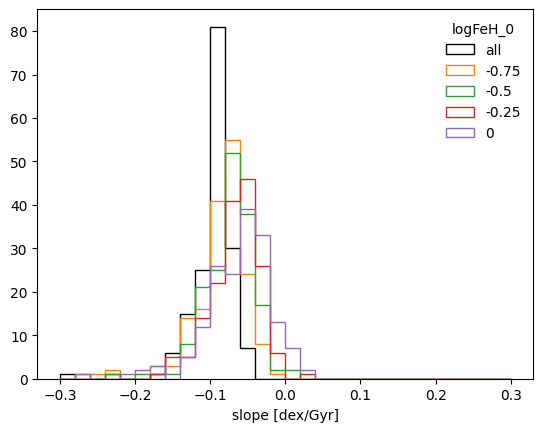

In [64]:
plt.hist(mlist[:,0], bins=np.linspace(-0.3, 0.3, 30+1), edgecolor='k', histtype='step', label='all')
for i in range(len(logFeH0_list)):
    plt.hist(mlist[:,i+1], bins=np.linspace(-0.3, 0.3, 30+1),
             histtype='step', label=str(logFeH0_list[i]))

plt.xlabel('slope [dex/Gyr]')
plt.legend(frameon=False, title='logFeH_0')

In [54]:
k = np.where(subIDs==172175)[0][0]

In [56]:
mlist[23]

array([-0.10943691, -0.13287737, -0.11125245, -0.087497  , -0.05751178])

(array([ 4.,  7.,  9., 11., 19., 27., 36., 27., 21.,  7.]),
 array([0.27914385, 0.33278475, 0.38642565, 0.44006655, 0.49370745,
        0.54734835, 0.60098925, 0.65463015, 0.70827105, 0.76191195,
        0.81555285]),
 <BarContainer object of 10 artists>)

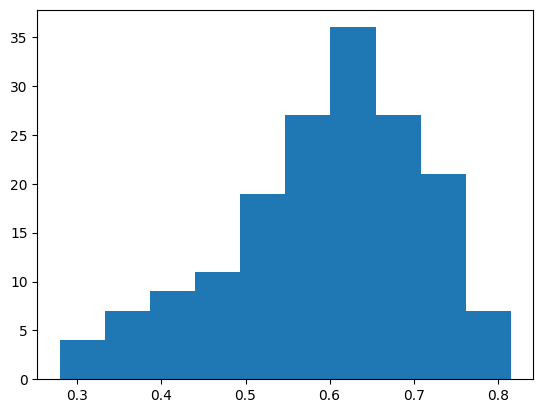

In [58]:
plt.hist(rlist[:,0]**2)

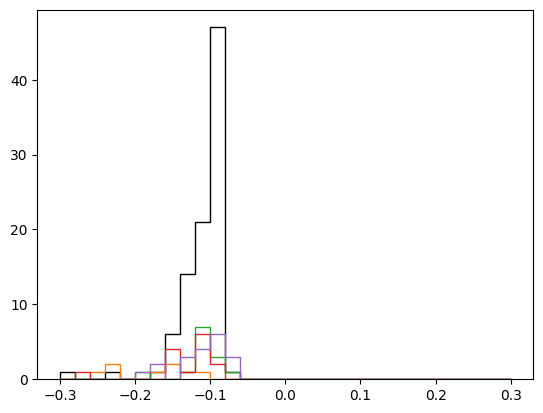

In [59]:
key = rlist[:,0]**2 > 0.6
plt.hist(mlist[key,0], bins=np.linspace(-0.3, 0.3, 30+1), edgecolor='k', histtype='step')
for i in range(len(logFeH0_list)):
    key = rlist[:,i+1]**2 > 0.6
    plt.hist(mlist[key,i+1], bins=np.linspace(-0.3, 0.3, 30+1), histtype='step')

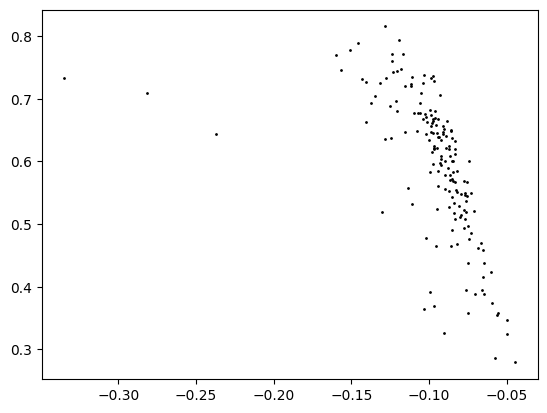

In [60]:
plt.scatter(mlist[:,0], rlist[:,0]**2, s=1, c='k')